<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/main/src/code/TC_Vmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# insert your desired path to work on
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
best_track/                            SAR_swath_images_VV+VH+VH/
categorisation.png                     SAR_swath_images_VV+VH+WS/
download_files.ipynb                   SAR_swath_images_VV+VH+WS_dilated/
identification.png                     SAR_swath_images_VV+VV+VV/
model_comparisons_between_datasets/    SAR_swath_images_WS+sWSO+cWSO/
model.png                              SAR_swath_images_WS+WS+WS/
parametric_model/                      SAR_swath_masks/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_nc/
SAR_swath_images_VH+VH+VH/             SAR_swath_Vmax/


In [ ]:
!pip install netcdf4

     |████████████████████████████████| 4.7MB 7.4MB/s 
     |████████████████████████████████| 317kB 40.2MB/s 


In [ ]:
# general imports
import netCDF4
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
import time
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.interpolate import interp1d
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Input
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import resnet50, mobilenet_v2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

np.set_printoptions(precision=4)

In [ ]:
def knots_to_m_sec(kts):
    """ Converts knots (kt) to meters/second (m/s) """
    if np.isnan(kts):
        return kts
    else:
        return kts * 0.514444

##1. Test dilation of land mask on category 1 data

In [ ]:
file_list_cat4 = glob.glob('SAR_swath_nc/category4/*.nc')
file_list_cat5 = [os.path.basename(x) for x in glob.glob('SAR_swath_nc/category5/*.nc')]
list_cat4 = [file for file in file_list_cat4 if os.path.basename(file) not in file_list_cat5]

#file_list_cat1 = glob.glob('SAR_swath_nc/category1/*.nc')
#file_list_cat2 = [os.path.basename(x) for x in glob.glob('SAR_swath_nc/category2/*.nc')]
#list_cat1 = [file for file in file_list_cat1 if os.path.basename(file) not in file_list_cat2]

print(len(list_cat4))
values = []

for single_file in list_cat4:
    full_info_image = netCDF4.Dataset(single_file, mode='r') 

    feature_wind = full_info_image.variables["wind_speed"][:]
    feature_wind = feature_wind[0]

    plt.imshow(feature_wind)
    plt.title("Original wind feature")
    plt.colorbar()
    plt.show()
    print("First Vmax value:", np.max(feature_wind))
    ind = np.unravel_index(np.argmax(feature_wind, axis=None), feature_wind.shape)
    print("Pixel for the Vmax found:", ind)

    mask = full_info_image.variables["mask_flag"][:]
    mask = mask[0]
    mask[mask != 0] = 1
    #np.int8(mask != 0)

    # dilate mask
    # source: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((11, 11), np.int8)
    dilation = cv2.dilate(mask,kernel,iterations = 1)
    feature_wind[dilation != 0] = 0

    #plt.imshow(dilation)
    #plt.colorbar()
    #plt.show()

    plt.imshow(feature_wind)
    plt.title("Wind feature with land mask")
    plt.colorbar()
    plt.show()
    print("Intermediate Vmax value:", np.max(feature_wind))

    heterogeneity_mask = full_info_image.variables["heterogeneity_mask"][:]
    heterogeneity_mask = heterogeneity_mask[0]

    plt.imshow(heterogeneity_mask)
    plt.title("heterogeneity mask")
    plt.colorbar()
    plt.show()
    print("heterogeneity mask unique values:", np.unique(heterogeneity_mask))

    feature_wind[heterogeneity_mask == 3] = 0
    feature_wind[heterogeneity_mask == 2] = 0
    plt.imshow(feature_wind)
    plt.title("Wind feature with both masks")
    plt.colorbar()
    plt.show()

    ind = np.unravel_index(np.argmax(feature_wind, axis=None), feature_wind.shape)
    ws_Vmax = np.max(feature_wind)
    print(os.path.basename(single_file))
    print("Final Vmax value:", ws_Vmax)
    print("Pixel for the Vmax found:", ind)

    values.append(ws_Vmax)
    #plt.imshow(feature_wind)
    #plt.title("Final image")
    #plt.colorbar()
    #plt.show()
    print("---------------------------------------")
print("Values:", values)
plt.hist(values)
plt.title("Category 4 Vmax distribution")

Output hidden; open in https://colab.research.google.com to view.

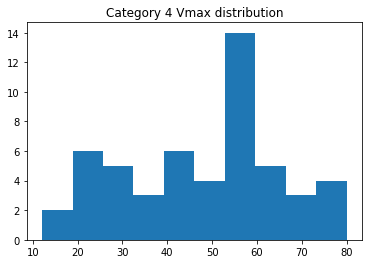

In [ ]:
plt.hist(values)
plt.title("Category 4 Vmax distribution")
plt.savefig("SAR_swath_Vmax/Category 4 Vmax distribution.png", bbox_inches='tight')

##2. Create dataframe with all Vmax values for all categories

In [ ]:
# dir to save results
save_dir = "SAR_swath_Vmax/with feature_wind[heterogeneity_mask == 2,3] = 0 and feature_wind[dilated_mask != 0] = 0"
os.makedirs(save_dir, exist_ok = True)
use_cat0 = False

# load generic best tracks CSV file
TC_dataset = pd.read_csv("best_track/ibtracs.since1980.list.v04r00.csv", header=0)

# load dataframe connecting .nc filename to TC Name and USA_ATCF_ID
nc_ID = pd.read_csv("SAR_swath_nc/cyclobs_tc_dataframe.csv", header=0)

# gather all .nc files from all categories
file_list = glob.glob('SAR_swath_nc/*/*.nc')

files = []
ids = []
cyclob_Vmax_list = []
ws_Vmax_list = []
best_track_Vmax_list = []
tmax_list = []
ws_Vmax_masked_list = []

cnt=0
for single_file in file_list:

    nc_filename = os.path.basename(single_file)
    df = nc_ID[nc_ID.data == nc_filename]

    # cyclob_Vmax is the Vmax value in the request url dataframe from Cyclobs API
    cyclob_Vmax = df['vmax (m/s)'].values
    id = df.sid.values

    ##############################
    try:
        # READ THE NC PRODUCT
        full_info_image = netCDF4.Dataset(single_file, mode='r') 

        # try to read this feature as it usually gives problems!
        feature_cross = full_info_image.variables["nrcs_detrend_cross"][:]

        tmax_units = datetime.datetime.strptime(full_info_image.measurementDate, '%Y-%m-%dT%H:%M:%SZ')
        tmax = tmax_units.strftime('%Y-%m-%d %H_%M_%S')

        # extract wind speed info from .nc product
        feature_wind = full_info_image.variables["wind_speed"][:]
        feature_wind = feature_wind[0]

        # ws_Vmax is the maximum wind speed of the product
        ws_Vmax = np.max(feature_wind)
        #print(ws_Vmax)

        # extract mask from .nc product
        mask = full_info_image.variables["mask_flag"][:]
        mask = mask[0]
        mask[mask != 0] = 1
        # dilate mask
        kernel = np.ones((11, 11), np.int8)
        mask_dilated = cv2.dilate(mask, kernel, iterations = 1)

        # extract heterogeneity mask from .nc product
        heterogeneity_mask = full_info_image.variables["heterogeneity_mask"][:]
        heterogeneity_mask = heterogeneity_mask[0]
        #print(np.unique(heterogeneity_mask))

        # set all mask pixels diff than 0 to 0
        feature_wind[mask_dilated != 0] = 0
        #feature_wind[heterogeneity_mask != 0] = 0
        feature_wind[heterogeneity_mask == 3] = 0
        feature_wind[heterogeneity_mask == 2] = 0

        # ws_Vmax_masked is the Vmax of the product after the application of the masks
        ws_Vmax_masked = np.max(feature_wind)
        if ws_Vmax != ws_Vmax_masked:
            cnt +=1
        full_info_image.close()
    
    except KeyError as err:
        # Creating KeyError instance for book keeping.
        print("Error:", err)
        full_info_image.close()
        continue
    ##############################

    # get rows in the TC best track that are taken in the same day of the TC
    day = tmax[:10]
    img_info = TC_dataset.loc[TC_dataset.ISO_TIME.str.contains(day)]
    img_info = img_info.loc[img_info.USA_ATCF_ID == id[0].upper()]

    for index, row in img_info.iterrows():
        img_info['ISO_TIME'][index] = datetime.datetime.strptime(img_info['ISO_TIME'][index], '%Y-%m-%d %H:%M:%S')
    img_info['USA_WIND'] = img_info['USA_WIND'].astype(float)
    aux = img_info[['ISO_TIME', 'USA_WIND']]

    df2 = pd.DataFrame([[tmax_units, np.nan]], columns=['ISO_TIME', 'USA_WIND'])
    #print(df2)
    aux = aux.append(df2, ignore_index=True)
    aux = aux.sort_values(by='ISO_TIME')
    #print(aux)

    interp = aux.interpolate()
    #print(interp)
    best_track_Vmax = interp.USA_WIND.loc[interp.ISO_TIME == tmax_units].values
    #print(best_track_Vmax)

    files.append(single_file)
    ids.append(id[0])
    cyclob_Vmax_list.append(cyclob_Vmax[0])
    best_track_Vmax_list.append(knots_to_m_sec(best_track_Vmax[0]))
    ws_Vmax_list.append(ws_Vmax)
    ws_Vmax_masked_list.append(ws_Vmax_masked)
    tmax_list.append(tmax)

data = {"nc": files, "sid": ids, "tmax": tmax_list, "Vmax_ws": ws_Vmax_list, 
        "Vmax_ws_masked": ws_Vmax_masked_list, "Vmax_cyclob": cyclob_Vmax_list, 
        "Vmax_best_track": best_track_Vmax_list}
data_df = pd.DataFrame(data)

print("Number of Vmax values that changed by applying the land mask and the heterogeneity mask:", cnt)

# save relevant information in a csv file that could be retrived with pandas in the future
data_df.to_csv("{}/Vmax_info_masked_both.csv".format(save_dir), index = False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,8,9,14,19,20,25,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Error: 'nrcs_detrend_cross'
Number of Vmax values that changed by applying the land mask and the heterogeneity mask: 267


### 2.1. Drop duplicated rows and timestamps not present in our dataset.

In [ ]:
#####################################################################################
# NOTE: 
# What reduces the dataset to a size of 227 is dropping duplicates and excluding .nc
# products that give an error while trying to read the nrcs_detrend_cross feature
#####################################################################################

dir = 'SAR_swath_images_VV+VH+WS'

dataset = pd.read_csv("{}/Vmax_info_masked_both.csv".format(save_dir))

# check indexes with duplicated tmax and keep the last one
dataset = dataset.drop_duplicates(subset=["tmax"], keep = 'last')

# eliminate rows with timestamps not present in our dataset
file_list = glob.glob('{}/*/*.png'.format(dir))

times = np.array([item.split("/")[-1][:-4] for item in file_list])
df_tmax = dataset.tmax.values

# this diff happened because I wasn't using try except nrcs_detrend_cross exception
diff = list(list(set(times)-set(df_tmax)) + list(set(df_tmax)-set(times)))
if len(diff) > 0:
    print(diff)
    idxs = []
    for item in diff:
        df = dataset.loc[dataset.tmax == item]

        for idx, row in df.iterrows():
            idxs.append(idx)
    dataset = dataset.drop(idxs)

# create category column
dataset["category"] = dataset["nc"].str.split('/', expand=True)[1]

if use_cat0:
    # load full_dataset.csv to get info on labels
    df = pd.read_csv('{}/csv/full_dataset.csv'.format(dir))
    df['tmax'] = df['image'].str.split("/").str[-1].str[:-4]
    #print(df)
    dataset = dataset.merge(df[['tmax', 'label']])
    
    # drop products where there is no eye
    #dataset = dataset[dataset.label != 0]
    # instead of dropping no-eye images, we can create "category0"
    dataset["category"] = np.where((dataset.label == 0), 'category0', dataset["category"])

dataset.reset_index(inplace = True, drop = True)
dataset.to_csv("{}/Vmax_info_masked_both_filtered.csv".format(save_dir), index = False)

print("cat0:", len(dataset[dataset.category == "category0"]))
print("cat1:", len(dataset[dataset.category == "category1"]))
print("cat2:", len(dataset[dataset.category == "category2"]))
print("cat3:", len(dataset[dataset.category == "category3"]))
print("cat4:", len(dataset[dataset.category == "category4"]))
print("cat5:", len(dataset[dataset.category == "category5"]))
dataset

cat0: 0
cat1: 70
cat2: 42
cat3: 51
cat4: 51
cat5: 13


,nc,sid,tmax,Vmax_ws,Vmax_ws_masked,Vmax_cyclob,Vmax_best_track,category
0,SAR_swath_nc/category1/s1a-iw-owi-cm-20180409t...,sh192018,2018-04-09 17_32_19,80.000000,13.280000,33,32.152750,category1
1,SAR_swath_nc/category1/s1a-ew-owi-cm-20190329t...,sh222019,2019-03-29 14_03_33,54.040001,54.040001,35,NaN,category1
2,SAR_swath_nc/category1/s1a-iw-owi-cm-20170504t...,sh182017,2017-05-04 07_14_33,80.000000,44.700001,42,41.155520,category1
3,SAR_swath_nc/category1/s1a-ew-owi-cm-20190324t...,sh212019,2019-03-24 10_38_56,66.533333,55.980000,40,NaN,category1
4,SAR_swath_nc/category1/s1b-ew-owi-cm-20180930t...,ep202018,2018-09-30 14_03_11,33.080002,32.340000,33,35.239414,category1
...,...,...,...,...,...,...,...,...
222,SAR_swath_nc/category5/s1a-ew-owi-cm-20180914t...,wp262018,2018-09-14 09_51_28,64.760002,64.760002,75,72.536604,category5
223,SAR_swath_nc/category5/s1b-ew-owi-cm-20180911t...,wp262018,2018-09-11 20_48_44,80.000000,80.000000,72,72.536604,category5
224,SAR_swath_nc/category5/s1a-ew-owi-cm-20180831t...,wp252018,2018-08-31 08_29_35,80.000000,80.000000,77,78.967154,category5
225,SAR_swath_nc/category5/s1a-iw-owi-cm-20170907t...,al112017,2017-09-07 10_30_39,79.519997,79.500000,78,74.594380,category5


### 2.2. Plot distribution of Vmax across categories for different vars.

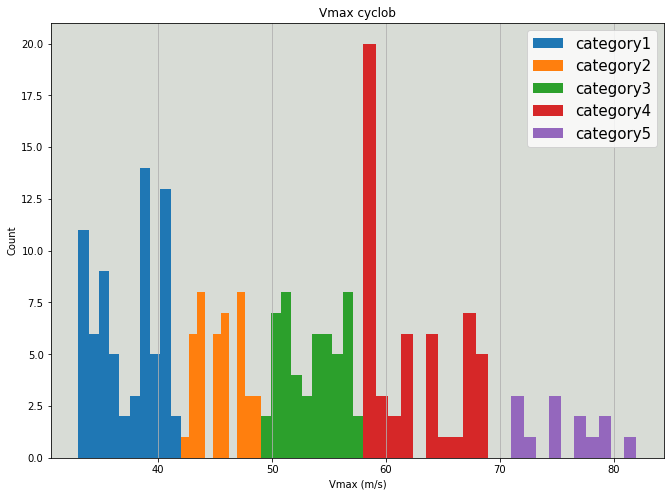

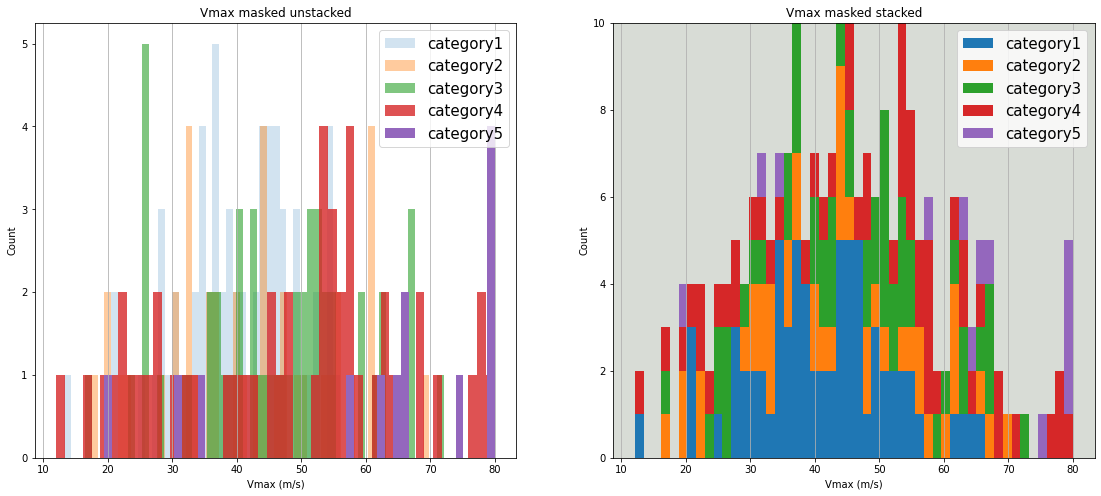

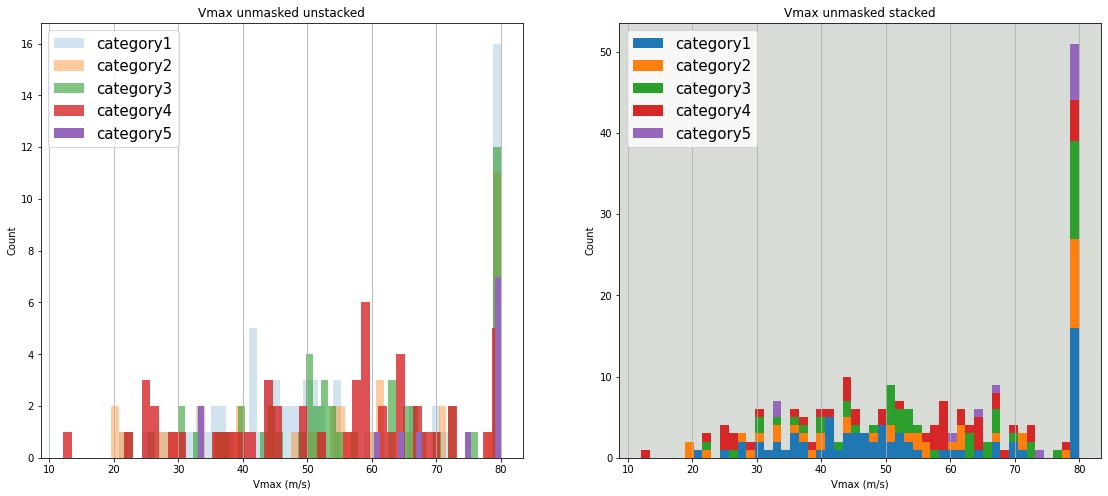

In [ ]:
#main_dir = "SAR_swath_Vmax/with feature_wind[heterogeneity_mask[0] != 0] = 0 and feature_wind[mask[0] != 0] = 0"
hist_dir = "{}/histograms".format(save_dir)
os.makedirs(hist_dir, exist_ok = True)
save_plots = True
n_bins = 50

dataset = pd.read_csv("{}/Vmax_info_masked_both_filtered.csv".format(save_dir))

#######################
###   Vmax_cyclob   ###
#######################
fig, ax = plt.subplots(figsize =(11,8))
rate = 0.2
for cat in range(1, 6):
    category = 'category'+str(cat)
    feature = dataset.where(dataset.category == category).loc[:, "Vmax_cyclob"]
    feature.hist(ax=ax, label=category)
ax.set(title = 'Vmax cyclob', ylabel = 'Count', xlabel = 'Vmax (m/s)')
ax.legend(fontsize = 15)
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')
plt.show()
if save_plots:
    fig.savefig("{}/Vmax_cyclob.png".format(hist_dir), bbox_inches='tight')


##########################
###   Vmax_ws_masked   ###
##########################
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(19,8))

for cat in range(1, 6):
    category = 'category'+str(cat)
    feature = dataset.where(dataset.category == category).loc[:, "Vmax_ws_masked"]
    feature.hist(ax=ax1, label=category, alpha = rate*cat, bins = n_bins)
ax1.set(title = 'Vmax masked unstacked', ylabel = 'Count', xlabel = 'Vmax (m/s)')
ax1.legend(fontsize = 15)
ax1.grid(axis='y')

cats = ['category1', 'category2', 'category3', 'category4', 'category5']
cat1 = dataset.where(dataset.category == 'category1').loc[:, "Vmax_ws_masked"]
cat2 = dataset.where(dataset.category == 'category2').loc[:, "Vmax_ws_masked"]
cat3 = dataset.where(dataset.category == 'category3').loc[:, "Vmax_ws_masked"]
cat4 = dataset.where(dataset.category == 'category4').loc[:, "Vmax_ws_masked"]
cat5 = dataset.where(dataset.category == 'category5').loc[:, "Vmax_ws_masked"]

ax2.hist([cat1, cat2, cat3, cat4, cat5], stacked=True, label = cats, bins = n_bins)
ax2.set(title = 'Vmax masked stacked', ylabel = 'Count', xlabel = 'Vmax (m/s)')
ax2.legend(fontsize = 15)
ax2.grid(axis='x')
ax2.set_facecolor('#d8dcd6')
plt.show()

if save_plots:
    fig.savefig("{}/Vmax_ws_masked.png".format(hist_dir), bbox_inches='tight')


###################
###   Vmax_ws   ###
###################
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(19,8))

for cat in range(1, 6):
    category = 'category'+str(cat)
    feature = dataset.where(dataset.category == category).loc[:, "Vmax_ws"]
    feature.hist(ax=ax1, label=category, alpha = rate*cat, bins = n_bins)
ax1.set(title = 'Vmax unmasked unstacked', ylabel = 'Count', xlabel = 'Vmax (m/s)')
ax1.legend(fontsize = 15)
ax1.grid(axis='y')
#ax.set_facecolor('#d8dcd6')

cats = ['category1', 'category2', 'category3', 'category4', 'category5']
cat1 = dataset.where(dataset.category == 'category1').loc[:, "Vmax_ws"]
cat2 = dataset.where(dataset.category == 'category2').loc[:, "Vmax_ws"]
cat3 = dataset.where(dataset.category == 'category3').loc[:, "Vmax_ws"]
cat4 = dataset.where(dataset.category == 'category4').loc[:, "Vmax_ws"]
cat5 = dataset.where(dataset.category == 'category5').loc[:, "Vmax_ws"]

ax2.hist([cat1, cat2, cat3, cat4, cat5], stacked=True, label = cats, bins = n_bins)
ax2.set(title = 'Vmax unmasked stacked', ylabel = 'Count', xlabel = 'Vmax (m/s)')
ax2.legend(fontsize = 15)
ax2.grid(axis='x')
ax2.set_facecolor('#d8dcd6')
plt.show()

if save_plots:
    fig.savefig("{}/Vmax_ws.png".format(hist_dir), bbox_inches='tight')

## 3. Train regression model

[1 4 0 4 1 2 2 0 0 0 1 2 0 1 3 3 1 3 1 4 1 0 5 0 0 0 1 0 0 4 0 1 0 1 3 0 5
 0 0 2 4 0 1 0 2 3]
Number of classes: 6
Epoch 1/50
15/15 [==============================] - 1s 15ms/step - loss: 1.7612 - accuracy: 0.3486 - val_loss: 1.7010 - val_accuracy: 0.5405

Epoch 00001: val_loss improved from inf to 1.70098, saving model to SAR_swath_Vmax/with feature_wind[heterogeneity_mask == 2,3] = 0 and feature_wind[dilated_mask != 0] = 0 and cat0/regression_results/Vmax_ws_masked_best_model.h5
Epoch 2/50
15/15 [==============================] - 0s 4ms/step - loss: 1.7107 - accuracy: 0.4385 - val_loss: 1.5955 - val_accuracy: 0.4865

Epoch 00002: val_loss improved from 1.70098 to 1.59551, saving model to SAR_swath_Vmax/with feature_wind[heterogeneity_mask == 2,3] = 0 and feature_wind[dilated_mask != 0] = 0 and cat0/regression_results/Vmax_ws_masked_best_model.h5
Epoch 3/50
15/15 [==============================] - 0s 4ms/step - loss: 1.6053 - accuracy: 0.3992 - val_loss: 1.4690 - val_accuracy: 0.4865

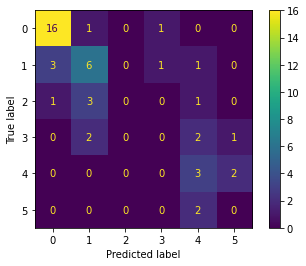

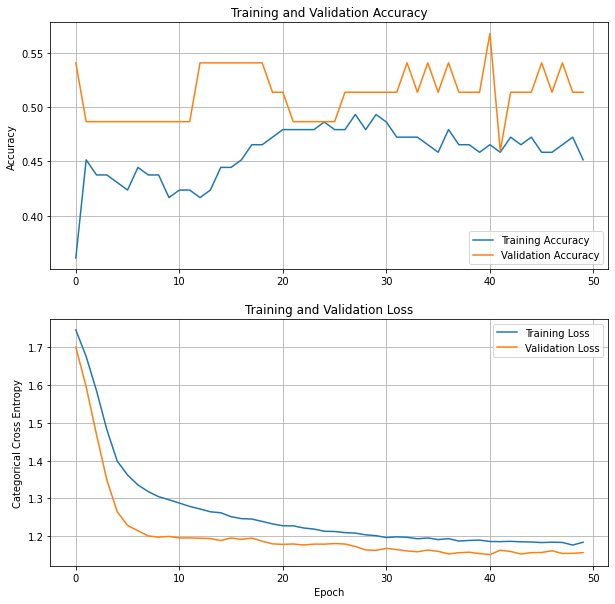

In [ ]:
# Importing the dataset
#main_dir = "SAR_swath_Vmax/with feature_wind[heterogeneity_mask[0] == 3] = 0"
save_dir = "SAR_swath_Vmax/with feature_wind[heterogeneity_mask == 2,3] = 0 and feature_wind[dilated_mask != 0] = 0 and cat0"
results_dir = "{}/regression_results".format(save_dir)
os.makedirs(results_dir, exist_ok= True)
save_plots = True

dataset = pd.read_csv("{}/Vmax_info_masked_both_filtered.csv".format(save_dir))

feature = "Vmax_ws_masked"
X = dataset.loc[:, feature].values
y = dataset.loc[:, "category"].str.extract('(\d+)').astype(int).values.flatten()
#X = X/X.max()
#print(X)


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
#print(X_test, y_test)
print(y_test)

# one hot encode outputs
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# count number of classes
nb_classes = y_test.shape[1]
print("Number of classes:", nb_classes)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)


# FEATURE SCALING
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#print(X_train, X_test)


# CREATE MODEL
model = Sequential()
model.add(Dense(32, activation = 'relu', input_dim = 1))    # adding the input layer and the first hidden layer
model.add(Dense(units = 32, activation = 'relu'))   # second hidden layer
model.add(Dense(units = 32, activation = 'relu'))   # third hidden layer 
model.add(Dense(nb_classes, activation='softmax'))   # output layer
#model.add(Dense(units = 1))

# COMPILE MODEL
model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])
#model.compile(optimizer = 'adam', loss = 'mean_squared_error')


# FIT THE MODEL
history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    batch_size = 10,
                    epochs = 50,
                    callbacks = ModelCheckpoint(results_dir + "/{}_best_model.h5".format(feature), verbose = 1, save_best_only = True)
                    )


# LOAD BEST MODEL
time.sleep(5) # guarantees enough time for weights to be saved and loaded afterwards, otherwise gives concurrency problems
print("Loaded best weights of the training")
model.load_weights(results_dir + "/{}_best_model.h5".format(feature))


# MAKE PREDICTIONS
y_pred = model.predict(X_test)
#print(y_pred)
predictions = [ np.argmax(t) for t in y_pred ]
#print(predictions)
y_test_non_category = [ np.argmax(t) for t in y_test ]

conf_mat = confusion_matrix(y_test_non_category, predictions, labels = [0,1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0,1,2,3,4,5])
conf_mat_display = disp.plot()
if save_plots:
    plt.savefig("{}/{}_confusion_matrix.jpg".format(results_dir, feature), bbox_inches='tight')


# PLOT TRAIN/VALIDATION LOSSES
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize=(10, 10))
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set(ylabel = "Accuracy",
        title = 'Training and Validation Accuracy')

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.grid(True)
ax2.legend(loc='upper right')
ax2.set(xlabel = 'Epoch', 
      ylabel = 'Categorical Cross Entropy',
      title = 'Training and Validation Loss')
plt.show()
if save_plots:
    fig.savefig("{}/{}_learning_curves.jpg".format(results_dir, feature), bbox_inches='tight')

# PLOT PREDICTIONS vs LABELS
#fig, ax = plt.subplots(figsize=(10, 10))
#ax.plot(y_test_non_category, '.', color = 'red', label = 'Real data')
#ax.plot(predictions, '.', color = 'blue', label = 'Predicted data')
#ax.set(title = 'Prediction')
#ax.legend()
#plt.show()

###3.1. Regression model structures tests.

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(1,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])


model = Sequential()
model.add(Dense(10, activation='relu', input_dim=1))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
